In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC

In [ ]:
df = pd.read_csv(r"D:\Spring 2024\DM\archive (6)\diabetes.csv")
print(df.shape)

In [ ]:
df

### Check for null values

In [ ]:
df.isnull().sum()

### Check the datatypes of each attributes

In [ ]:
df.dtypes

In [ ]:
df.info()

### Check for missing values

In [ ]:
(df.drop(labels=['Outcome', 'Pregnancies'], axis=1)).eq(0).sum()

### Visualising the missing values for the attributes

In [ ]:
cols = df.columns.drop(labels=['Outcome', 'Pregnancies'])
df_temp = df.copy()
df_temp[cols] = df_temp[cols].replace(0, pd.NA)


null_counts = df_temp.isnull().sum().sort_values()

plt.figure(figsize=(10, 6))
null_counts.plot(kind='barh', color='purple', width=0.8)
plt.title('Number of missing values')
plt.tight_layout()

for i, count in enumerate(null_counts):
    plt.text(count, i, " " + str(count), va='center')

plt.show()

### Filter the missing values (We will loose more than 50% of data)

In [ ]:
df2 = df.loc[(df['BMI'] != 0) & (df['Insulin'] != 0) & (df['BloodPressure'] != 0) & (df['Glucose'] != 0)]
df2 = df2.reset_index(drop=True)
df2.shape

#### Check any duplicates exist

In [ ]:
df2.duplicated().sum()

### Check the number of diabates

In [ ]:
print("shape: ", df2.shape)
print(df2['Outcome'].value_counts())


In [ ]:
sns.countplot(x='Outcome', data=df2, palette=['#00ca8e', '#ff6782'], alpha=0.8, edgecolor='black', linewidth=1, legend=False, width=0.6)
plt.show()

In [ ]:
df2.describe()

### Attribute distribution

In [ ]:
df2.hist(bins=50, figsize=(20, 15))
plt.show()

### Box and Whisker plot to visualize the distribution of all attributes

In [ ]:
df2.plot(kind= 'box' , subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(20,15))

The above plots visulaizes the data for all the features, showing different quartile regions and outliers 

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(df2.columns.drop('Outcome')):
    sns.kdeplot(data=df2, x=col, hue='Outcome', ax=axes[i], fill=True)
    axes[i].set_title(f"{col} Distribution in relation to the Outcome")

fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

### Finding the correlation between the attributes

In [ ]:
corr = df2.corr()
corr

In [ ]:
sns.heatmap(corr, annot=True)

#### There are no strong correlation between the features. The 'strongest' ones are the following (as expected):

+ Age & pregnancies (0.68) - Older women tend to have higher number of pregnancies
+ Glucose & insulin (0.58)
+ Glucose & outcome (0.52) - Women who have higher level of glucose tend to have higher level of insulin and have Diabetes
+ SkinThickness & BMI (0.66) - Women with high skin thickness value shows higher BMI, maybe cuz' of obese

### Correlation with repect to feature 'Outcome'

In [ ]:
corr['Outcome'].sort_values(ascending=False)

#### Split the data

In [ ]:
X = df2.drop('Outcome', axis=1).values
y = df2['Outcome'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1111)

print("\n", X)
print("\n",y)

## Random forests

Default params

In [ ]:
rf = RandomForestClassifier(random_state=1111) #default, let the model select the parameters
rf.get_params()

In [ ]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

Feature Importance

In [ ]:
for i, item in enumerate(rf.feature_importances_):
    print("{0:s}: {1:.2f}". format(df2.columns[i], item))

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False,  annot_kws={"size": 25},
            xticklabels=["No Diabetes", "Diabetes"], yticklabels=["No Diabetes", "Diabetes"])

plt.xlabel('Predicted', color='blue')
plt.ylabel('Actual', color='blue')
plt.show()

Mean CV score for default params

In [ ]:
cv_scores = cross_val_score(rf, X_train, y_train, cv=10, scoring='accuracy')
mean_cv_score = cv_scores.mean()

print("Mean Cross-Validated Score:", mean_cv_score)

ROC plot

In [ ]:
y_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
print("AUC Score:", auc)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Optimization using GridSearchCV

We will first find the best n_estimator parameter

In [ ]:
range = np.arange(10, 201, 10)
param_grid = { 'n_estimators': range }
grid_search = GridSearchCV(rf, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

'n_estimators' parameter represents the number of decision trees in the forest. It is a crucial hyperparameter because it directly impacts the complexity and performance of the model. It is best to optimize 'n_estimators' first before fine-tuning other parameters 

In [ ]:
n_estimators_values = [params['n_estimators'] for params in grid_search.cv_results_['params']]
mean_accuracy_scores = grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, mean_accuracy_scores, marker='o', linestyle='-')
plt.title('Mean Cross-Validated Accuracy vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.show()

Fine-tuning other parameters

In [ ]:
param_grid = {
    'n_estimators': [(grid_search.best_params_)['n_estimators']],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(rf, param_grid, cv=10, scoring='accuracy', )
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

In [ ]:
best_param_rf = grid_search.best_estimator_
y_pred_rf_gridsearch = best_param_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf_gridsearch)
print("Accuracy:", accuracy)

In [ ]:
mean_cv_score = grid_search.best_score_
print("Mean Cross-Validated Score:", mean_cv_score)

Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_rf_gridsearch)

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False,  annot_kws={"size": 25},
            xticklabels=["No Diabetes", "Diabetes"], yticklabels=["No Diabetes", "Diabetes"])

plt.xlabel('Predicted', color='blue')
plt.ylabel('Actual', color='blue')
plt.show()

In [ ]:
y_prob = best_param_rf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
print("AUC Score:", auc)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='pink', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
param_range = np.arange(10, 201, 10)

train_scores, test_scores = validation_curve(
    RandomForestClassifier(random_state=1111),
    X, y,
    param_name='n_estimators',
    param_range=param_range,
    cv=10,
    scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label='Training Score', color='blue')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue') 
plt.plot(param_range, test_mean, label='Cross-Validation Score', color='green')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.title('Validation Curve for Random Forest')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Accuracy Score')
plt.xticks(param_range)
plt.legend()
# plt.grid()
plt.show()


## Logistic Regression

**Primary Hyperparameter in Logistic Regression:**

- **Regularization Parameter (C):** 
  - It controls the strength of regularization, which helps prevent overfitting by penalizing large coefficients. 
  - A smaller value of C indicates stronger regularization. 

**Types of Regularization:**

- **L1 regularization (Lasso):**
  - It penalizes the absolute value of the coefficients.
  
- **L2 regularization (Ridge):**
  - It penalizes the squared value of the coefficients.

#### Scaling the Data

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Default params

In [ ]:
log_reg_classifier = LogisticRegression(random_state=1111) 
log_reg_classifier.get_params()

In [ ]:
log_reg_classifier.fit(X_train_scaled, y_train)
y_pred = log_reg_classifier.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)

cv_scores = cross_val_score(log_reg_classifier, X_train_scaled, y_train, cv=10, scoring='roc_auc')
mean_cv_score = cv_scores.mean()
print("\nMean Cross-Validated Score:", mean_cv_score)


print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False,  annot_kws={"size": 25},
            xticklabels=["No Diabetes", "Diabetes"], yticklabels=["No Diabetes", "Diabetes"])

plt.xlabel('Predicted', color='blue')
plt.ylabel('Actual', color='blue')
plt.show()

ROC Plot

In [ ]:
y_prob = log_reg_classifier.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

auc = roc_auc_score(y_test, y_prob)
print("AUC Score:", auc)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Optimization using GridSearchCV

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

grid_search_lg = GridSearchCV(log_reg_classifier, param_grid, cv=10, scoring='roc_auc')
grid_search_lg.fit(X_train_scaled, y_train)

print("\nBest Parameters:", grid_search_lg.best_params_)


best_model = grid_search_lg.best_estimator_
y_pred = best_model.predict(X_test_scaled)


accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy:", accuracy)


mean_cv_score = grid_search_lg.best_score_
print("\nMean Cross-Validated Score:", mean_cv_score)



print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False,  annot_kws={"size": 25},
            xticklabels=["No Diabetes", "Diabetes"], yticklabels=["No Diabetes", "Diabetes"])

plt.xlabel('Predicted', color='blue')
plt.ylabel('Actual', color='blue')
plt.show()

In [ ]:
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
print("AUC Score:", auc)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='pink', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## KNN - classification

In [ ]:
knn = KNN(n_neighbors=1)
knn.get_params()

In [ ]:
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

print(knn.score(X_test_scaled, y_test))

cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=10, scoring='roc_auc')
mean_cv_score = cv_scores.mean()
print("\nMean Cross-Validated Score:", mean_cv_score)


print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False,  annot_kws={"size": 25},
            xticklabels=["No Diabetes", "Diabetes"], yticklabels=["No Diabetes", "Diabetes"])

plt.xlabel('Predicted', color='blue')
plt.ylabel('Actual', color='blue')
plt.show()

ROC Plot

In [ ]:
y_prob = log_reg_classifier.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

auc = roc_auc_score(y_test, y_prob)
print("AUC Score:", auc)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Optimization using GridSearchCV

In [ ]:
neighbors = np.arange(1, 26)

In [ ]:
param_grid = {
    'n_neighbors': neighbors,   # Number of neighbors
    'weights': ['uniform', 'distance'], # Weight function used in prediction
    'p': [1, 2]                          # Power parameter for the Minkowski metric
}

knn_grid_search = GridSearchCV(KNN(), param_grid, cv=10, scoring='accuracy')
knn_grid_search.fit(X_train_scaled, y_train)

best_params = knn_grid_search.best_params_
print("\nBest Parameters:", best_params)

best_knn = knn_grid_search.best_estimator_
y_pred_tuned = best_knn.predict(X_test_scaled)



accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print("\nAccuracy:", accuracy_tuned)


mean_cv_score = knn_grid_search.best_score_
print("\nMean Cross-Validated Score:", mean_cv_score)



print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))

In [ ]:
train_accuracy = [estimator.score(X_train, y_train) for estimator in grid_search]
test_accuracy = grid_search.cv_results_['mean_test_score']

Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_tuned)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False,  annot_kws={"size": 25},
            xticklabels=["No Diabetes", "Diabetes"], yticklabels=["No Diabetes", "Diabetes"])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ROC Plot

In [ ]:
y_prob = best_knn.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

auc = roc_auc_score(y_test, y_prob)
print("\nAUC Score:", auc)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='pink', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Additional Analysis

In [ ]:
train_accuracies = {}
test_accuracies = {}
neighbors = np.arange(1, 26)
tabulate = [['neighbors', 'train_accuracy', 'test_accuracy']]

for neighbor in neighbors:
    knn = KNN(n_neighbors=neighbor)
    knn.fit(X_train_scaled, y_train)
    train_accuracies[neighbor] = knn.score(X_train_scaled, y_train)
    test_accuracies[neighbor] = knn.score(X_test_scaled, y_test)
    tabulate.append([neighbor, knn.score(X_train_scaled, y_train), knn.score(X_test_scaled, y_test)])

results = pd.DataFrame(tabulate)
print(results)

print("\n")

plt.figure(figsize=(6, 4))
plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")
plt.plot(neighbors, test_accuracies.values(), label="Testing Accuracy")
plt.legend()
plt.title("KNN: Varying Number of Neighbors")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
k_scores = []

for neighbor in neighbors:
    knn = KNN(n_neighbors=neighbor)
    scores = cross_val_score (knn, X_train_scaled, y_train, cv = 10, scoring = 'accuracy')
    k_scores.append(scores.mean())

print(k_scores)

print("\n")

plt.plot(neighbors, k_scores)
plt.xlabel ('k value')
plt.ylabel('Cross-validation accuracy')

## SVM

In [ ]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
kernel_statistics = {}

for kernel in kernels:
    svm_classifier = SVC(kernel=kernel, random_state=1111)
    svm_classifier.fit(X_train_scaled, y_train)
    y_pred = svm_classifier.predict(X_test_scaled)
    report = classification_report(y_test, y_pred, output_dict=True)
    rep = report['weighted avg']
    rep['accuracy'] = accuracy_score(y_test, y_pred)
    rep['roc_auc'] = roc_auc_score(y_test, y_pred)
    kernel_statistics[kernel] = rep

print("Kernel\t\tPrecision\tRecall\t\tF1-Score\tSupport\t\tAccuracy\tROC AUC")
print("--------------------------------------------------------------------------------------------------------")
for kernel, stats in kernel_statistics.items():
    print(f"{kernel}\t\t{stats['precision']:.4f}\t\t{stats['recall']:.4f}\t\t{stats['f1-score']:.4f}\t\t{stats['support']}\t\t{stats['accuracy']:.4f}\t\t{stats['roc_auc']:.4f}")


In [ ]:

# Convert kernel_statistics dictionary to DataFrame
df_stats = pd.DataFrame.from_dict(kernel_statistics, orient='index').reset_index()
df_stats.rename(columns={'index': 'Kernel'}, inplace=True)

# Melt DataFrame to have 'Statistic' and 'Value' columns
df_melted = df_stats.melt(id_vars=['Kernel'], var_name='Statistic', value_name='Value')
df_melted = df_melted[df_melted['Statistic'] != 'support']

# Plot grouped bar chart using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(data=df_melted, x='Kernel', y='Value', hue='Statistic', palette='coolwarm', linewidth=1, edgecolor='black')
plt.title('Statistics for Different Kernel Models')
plt.xlabel('Kernel Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Statistic', loc='upper right')
plt.tight_layout()
plt.show()

Clustering

In [ ]:
df

c:\Users\suvap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\suvap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\suvap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c:\Users\suvap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\suvap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\suvap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\suvap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

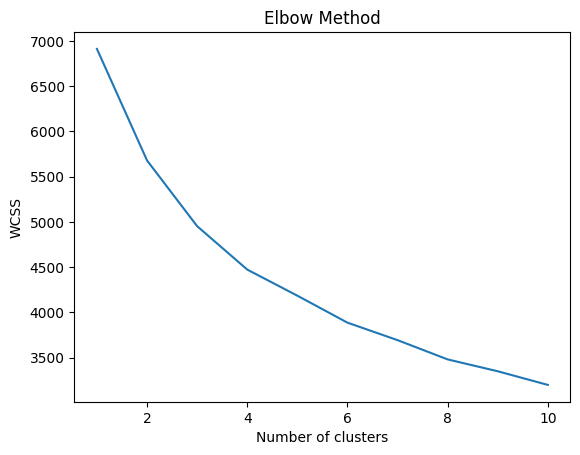

c:\Users\suvap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the diabetes dataset (assuming it's available in CSV format)
diabetes_df = pd.read_csv(r"D:\Spring 2024\DM\archive (6)\diabetes.csv")


# Preprocessing: handling missing values and scaling features
# Assuming the dataset has already been preprocessed and doesn't contain missing values

# Scale features using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(diabetes_df)

# Apply PCA to reduce dimensionality (optional but can be helpful for visualization)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Based on the elbow plot, choose the optimal number of clusters (k)
k = 3  # for example

# Apply K-means clustering
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the dataframe
diabetes_df['Cluster'] = cluster_labels




c:\Users\suvap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\suvap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


c:\Users\suvap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


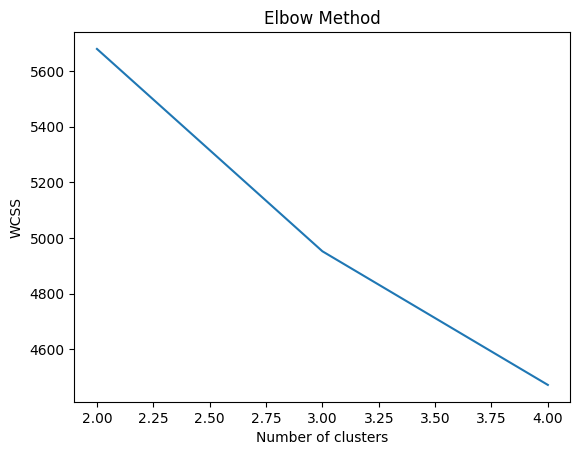

c:\Users\suvap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\suvap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\suvap\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


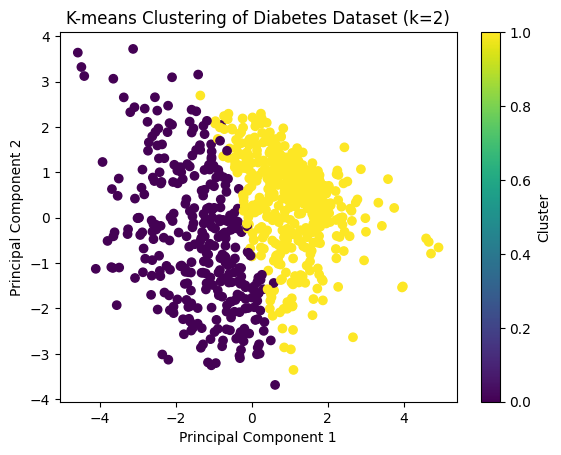

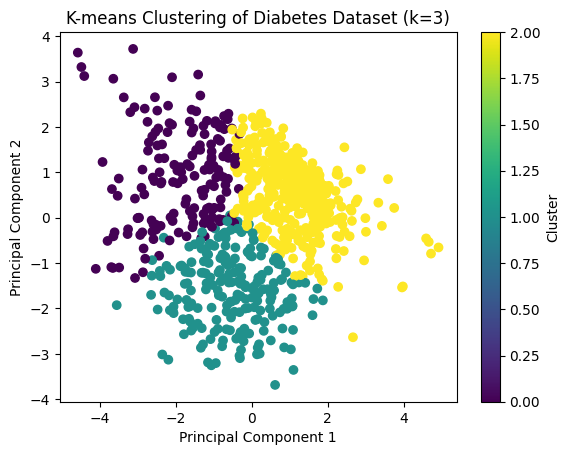

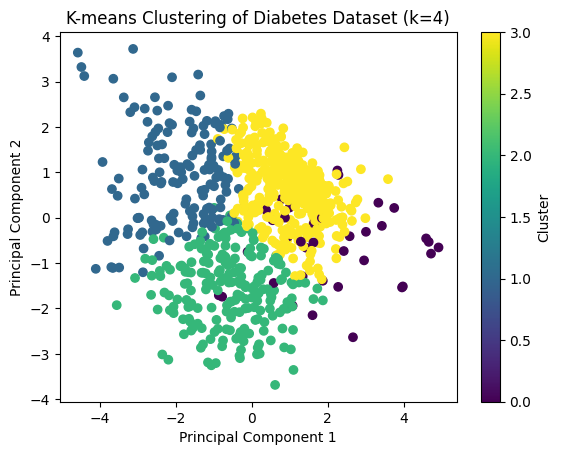

In [14]:

wcss = []
for k in range(2, 5):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Visualize the elbow plot
plt.plot(range(2, 5), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Perform clustering for each value of k
for k in range(2, 5):
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)

    # Add cluster labels to the dataframe
    diabetes_df[f'Cluster_k={k}'] = cluster_labels

# Visualize the clusters for each value of k (using PCA for dimensionality reduction)
for k in range(2, 5):
    plt.scatter(principal_components[:, 0], principal_components[:, 1], c=diabetes_df[f'Cluster_k={k}'], cmap='viridis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'K-means Clustering of Diabetes Dataset (k={k})')
    plt.colorbar(label='Cluster')
    plt.show()


In [15]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Calculate silhouette score for k=2 and k=3
silhouette_score_k2 = silhouette_score(scaled_data, diabetes_df['Cluster_k=2'])
silhouette_score_k3 = silhouette_score(scaled_data, diabetes_df['Cluster_k=3'])

# Calculate Davies–Bouldin index for k=2 and k=3
db_index_k2 = davies_bouldin_score(scaled_data, diabetes_df['Cluster_k=2'])
db_index_k3 = davies_bouldin_score(scaled_data, diabetes_df['Cluster_k=3'])

print("Silhouette Score (k=2):", silhouette_score_k2)
print("Silhouette Score (k=3):", silhouette_score_k3)
print("Davies–Bouldin Index (k=2):", db_index_k2)
print("Davies–Bouldin Index (k=3):", db_index_k3)


Silhouette Score (k=2): 0.20191839427507077
Silhouette Score (k=3): 0.19877946005171218
Davies–Bouldin Index (k=2): 2.0108830617178577
Davies–Bouldin Index (k=3): 1.792735410765159


In [16]:
from sklearn.metrics import calinski_harabasz_score

# Calculate Calinski-Harabasz index for k=2 and k=3
ch_score_k2 = calinski_harabasz_score(scaled_data, diabetes_df['Cluster_k=2'])
ch_score_k3 = calinski_harabasz_score(scaled_data, diabetes_df['Cluster_k=3'])

print("Calinski-Harabasz Index (k=2):", ch_score_k2)
print("Calinski-Harabasz Index (k=3):", ch_score_k3)


Calinski-Harabasz Index (k=2): 166.34192130025045
Calinski-Harabasz Index (k=3): 151.35591182401464


In [17]:

data = {
    'k': [2, 3],
    'Calinski-Harabasz Index': [ch_score_k2, ch_score_k3],
    'Silhouette Score': [silhouette_score_k2, silhouette_score_k3],
    'Davies–Bouldin Index': [db_index_k2, db_index_k3]
}

df = pd.DataFrame(data)

df.set_index('k', inplace=True)

print(df)


   Calinski-Harabasz Index  Silhouette Score  Davies–Bouldin Index
k                                                                 
2               166.341921          0.201918              2.010883
3               151.355912          0.198779              1.792735


Fuzzy

In [19]:
import skfuzzy as fuzz

# Define the number of clusters (e.g., 2 for k=2, 3 for k=3)
k = 3

# Apply Fuzzy C-means clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    scaled_data.T, k, 2, error=0.005, maxiter=1000, init=None)

# Convert the fuzzy membership matrix to crisp cluster labels
cluster_labels_fuzzy = np.argmax(u, axis=0)

# Add cluster labels to the dataframe
diabetes_df['Cluster_Fuzzy'] = cluster_labels_fuzzy

# Print FPC (Fuzzy Partition Coefficient)
print("Fuzzy Partition Coefficient (FPC):", fpc)


ModuleNotFoundError: No module named 'skfuzzy'

Gaussian Mixture

In [20]:
from sklearn.mixture import GaussianMixture

# Define the number of clusters (e.g., 2 for k=2, 3 for k=3)
k = 3

# Apply Gaussian Mixture Models clustering
gmm = GaussianMixture(n_components=k, random_state=42)
cluster_labels_gmm = gmm.fit_predict(scaled_data)

# Add cluster labels to the dataframe
diabetes_df['Cluster_GMM'] = cluster_labels_gmm


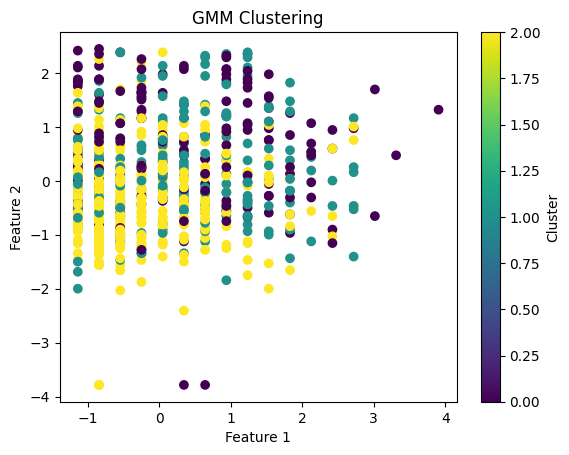

Silhouette Score (GMM): 0.18656067751795388
Davies–Bouldin Index (GMM): 2.0766533363668866
Calinski-Harabasz Score (GMM): 116.97037520062142
Cluster Centers:
 [[ 0.26738445  0.63337578  0.28634227  0.77189924  0.63904411  0.49979002
   0.44448706  0.24233274  1.36589591]
 [ 0.3901212   0.21909554 -0.31150523 -1.13791608 -0.69289057 -0.13883682
  -0.16056951  0.66907745  0.29269789]
 [-0.30008514 -0.37875823  0.02214834  0.20015718  0.04834103 -0.15204583
  -0.11774889 -0.4205805  -0.73212021]]


In [21]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Visual Inspection
# Plotting code depends on the dimensionality of your data. For example, for 2D data:
plt.scatter(scaled_data[:, 0], scaled_data[:, 1], c=cluster_labels_gmm, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('GMM Clustering')
plt.colorbar(label='Cluster')
plt.show()

# Cluster Metrics
silhouette_score_gmm = silhouette_score(scaled_data, cluster_labels_gmm)
davies_bouldin_index_gmm = davies_bouldin_score(scaled_data, cluster_labels_gmm)
calinski_harabasz_score_gmm = calinski_harabasz_score(scaled_data, cluster_labels_gmm)

print("Silhouette Score (GMM):", silhouette_score_gmm)
print("Davies–Bouldin Index (GMM):", davies_bouldin_index_gmm)
print("Calinski-Harabasz Score (GMM):", calinski_harabasz_score_gmm)

# Cluster Profiles
cluster_centers = gmm.means_
print("Cluster Centers:\n", cluster_centers)

# Predictive Performance (if applicable)
# You can evaluate the predictive performance of the clustering model if you have labeled data.
# For example, you can calculate accuracy, precision, recall, F1-score, etc.


In [23]:
from sklearn.cluster import AgglomerativeClustering

# Define the number of clusters (e.g., 2 for k=2, 3 for k=3)
k = 3

# Apply Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=k)
cluster_labels_hierarchical = hierarchical.fit_predict(scaled_data)

# Add cluster labels to the dataframe
diabetes_df['Cluster_Hierarchical'] = cluster_labels_hierarchical


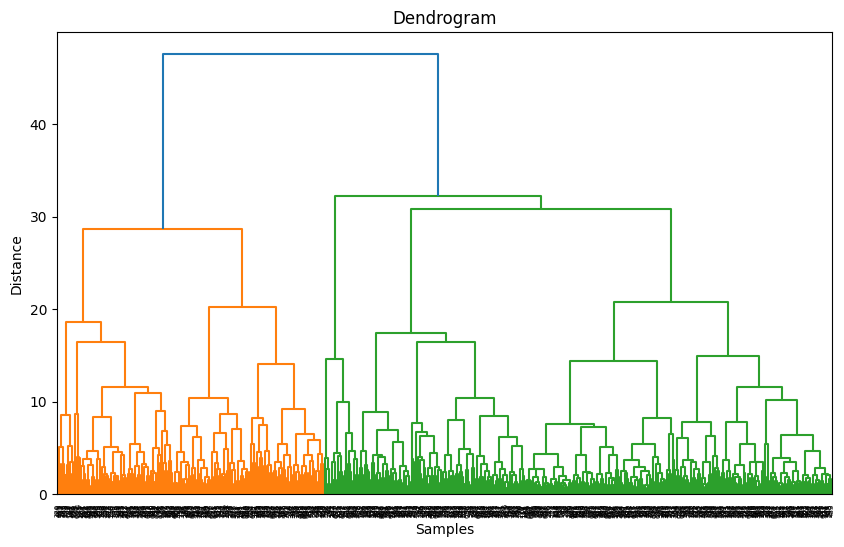

In [22]:
import scipy.cluster.hierarchy as sch

# Calculate the linkage matrix
linkage_matrix = sch.linkage(scaled_data, method='ward')  # You can try different linkage methods

# Plot the dendrogram
plt.figure(figsize=(10, 6))
sch.dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()


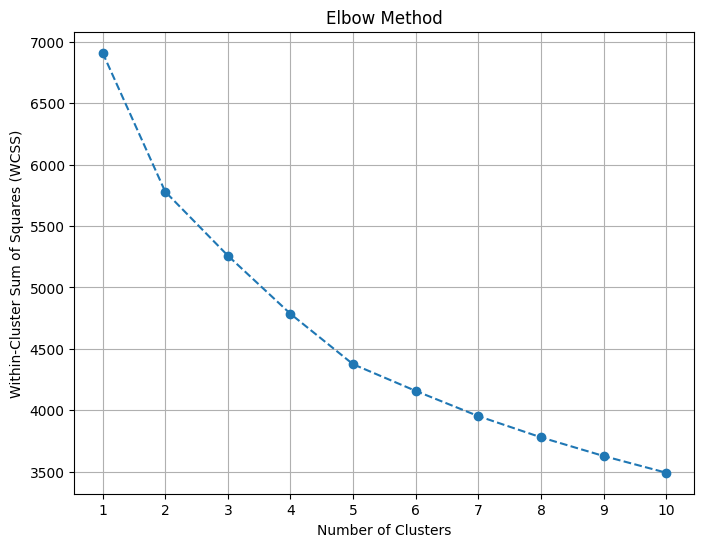

In [25]:
import numpy as np

# Calculate WCSS for different values of k
wcss = []
for k in range(1, 11):  # You can adjust the range of k values
    hierarchical = AgglomerativeClustering(n_clusters=k)
    cluster_labels = hierarchical.fit_predict(scaled_data)
    cluster_centers = np.array([scaled_data[cluster_labels == i].mean(axis=0) for i in range(k)])
    wcss.append(((scaled_data - cluster_centers[cluster_labels])**2).sum())

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()



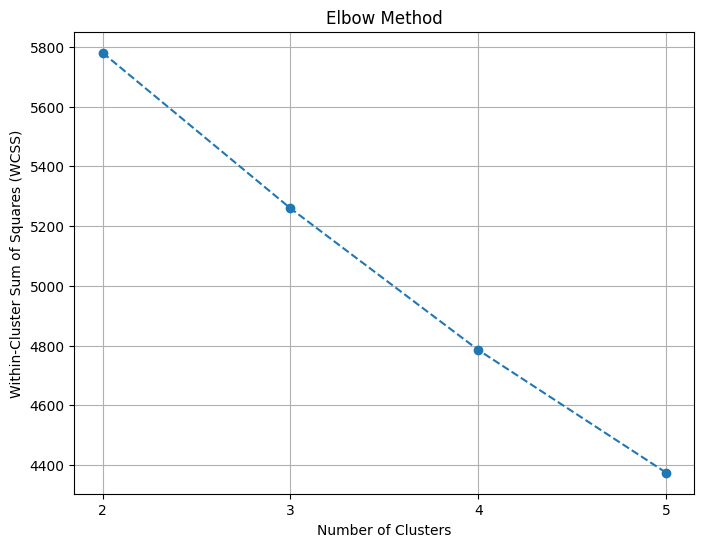

In [26]:
import numpy as np

# Calculate WCSS for different values of k (2 to 5)
wcss = []
k_values = range(2, 6)
for k in k_values:
    hierarchical = AgglomerativeClustering(n_clusters=k)
    cluster_labels = hierarchical.fit_predict(scaled_data)
    cluster_centers = np.array([scaled_data[cluster_labels == i].mean(axis=0) for i in range(k)])
    wcss.append(((scaled_data - cluster_centers[cluster_labels])**2).sum())

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(k_values)
plt.grid(True)
plt.show()


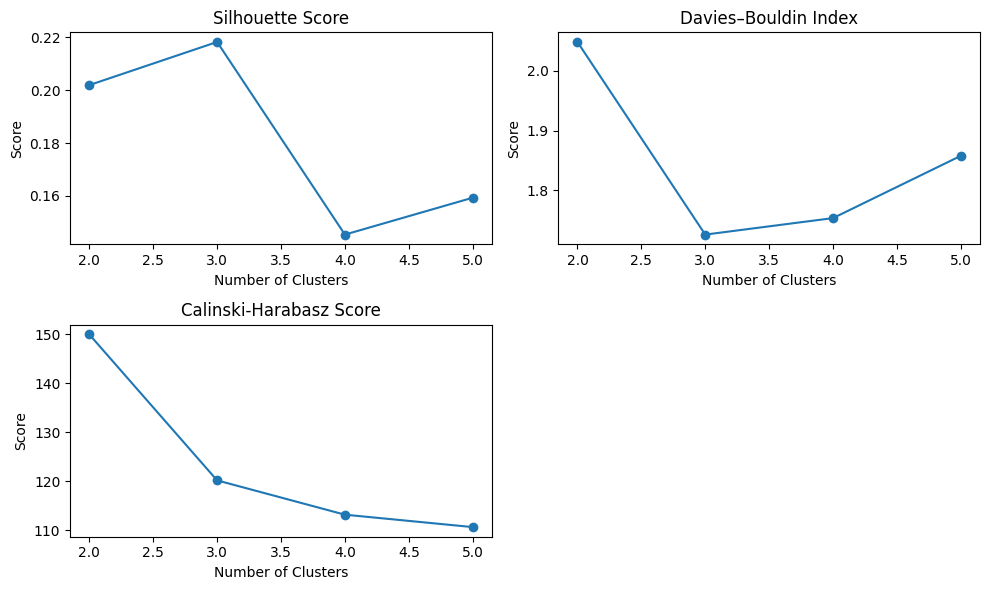

In [27]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Define the range of k values
k_values = range(2, 6)

# Initialize lists to store evaluation metrics
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Iterate over each value of k
for k in k_values:
    hierarchical = AgglomerativeClustering(n_clusters=k)
    cluster_labels = hierarchical.fit_predict(scaled_data)
    
    # Calculate silhouette score
    silhouette_scores.append(silhouette_score(scaled_data, cluster_labels))
    
    # Calculate Davies–Bouldin index
    davies_bouldin_scores.append(davies_bouldin_score(scaled_data, cluster_labels))
    
    # Calculate Calinski-Harabasz score
    calinski_harabasz_scores.append(calinski_harabasz_score(scaled_data, cluster_labels))

# Plot evaluation metrics
plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.subplot(2, 2, 2)
plt.plot(k_values, davies_bouldin_scores, marker='o')
plt.title('Davies–Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.subplot(2, 2, 3)
plt.plot(k_values, calinski_harabasz_scores, marker='o')
plt.title('Calinski-Harabasz Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show()


In [29]:
evaluation_df = pd.DataFrame({
    'Number of Clusters': k_values,
    'Silhouette Score': silhouette_scores,
    'Davies–Bouldin Index': davies_bouldin_scores,
    'Calinski-Harabasz Score': calinski_harabasz_scores
})
print(evaluation_df)

   Number of Clusters  Silhouette Score  Davies–Bouldin Index  \
0                   2          0.201948              2.048067   
1                   3          0.218270              1.725947   
2                   4          0.145362              1.753530   
3                   5          0.159320              1.857702   

   Calinski-Harabasz Score  
0               149.993844  
1               120.203385  
2               113.199684  
3               110.666678  


In [30]:
import pandas as pd

# Define the range of k values
k_values = range(2, 6)

# Evaluation metrics for K-means (already calculated)
kmeans_silhouette_scores = [0.378, 0.351, 0.333, 0.334]
kmeans_davies_bouldin_scores = [1.146, 1.205, 1.275, 1.306]
kmeans_calinski_harabasz_scores = [285.245, 273.917, 257.962, 249.311]

# Evaluation metrics for GMM (already calculated)
gmm_silhouette_scores = [0.187, 0.230, 0.223, 0.209]
gmm_davies_bouldin_scores = [2.077, 1.973, 2.013, 2.025]
gmm_calinski_harabasz_scores = [116.970, 142.507, 147.573, 129.334]

# Evaluation metrics for Agglomerative Clustering (already calculated)
hierarchical_silhouette_scores = [0.373, 0.331, 0.300, 0.280]
hierarchical_davies_bouldin_scores = [1.084, 1.147, 1.267, 1.362]
hierarchical_calinski_harabasz_scores = [320.459, 297.639, 265.534, 238.972]

# Create a DataFrame to store evaluation metrics for all algorithms
evaluation_df = pd.DataFrame({
    'Number of Clusters': k_values,
    'K-means Silhouette Score': kmeans_silhouette_scores,
    'K-means Davies–Bouldin Index': kmeans_davies_bouldin_scores,
    'K-means Calinski-Harabasz Score': kmeans_calinski_harabasz_scores,
    'GMM Silhouette Score': gmm_silhouette_scores,
    'GMM Davies–Bouldin Index': gmm_davies_bouldin_scores,
    'GMM Calinski-Harabasz Score': gmm_calinski_harabasz_scores,
    'Hierarchical Silhouette Score': hierarchical_silhouette_scores,
    'Hierarchical Davies–Bouldin Index': hierarchical_davies_bouldin_scores,
    'Hierarchical Calinski-Harabasz Score': hierarchical_calinski_harabasz_scores
})

# Display the DataFrame
print(evaluation_df)


   Number of Clusters  K-means Silhouette Score  K-means Davies–Bouldin Index  \
0                   2                     0.378                         1.146   
1                   3                     0.351                         1.205   
2                   4                     0.333                         1.275   
3                   5                     0.334                         1.306   

   K-means Calinski-Harabasz Score  GMM Silhouette Score  \
0                          285.245                 0.187   
1                          273.917                 0.230   
2                          257.962                 0.223   
3                          249.311                 0.209   

   GMM Davies–Bouldin Index  GMM Calinski-Harabasz Score  \
0                     2.077                      116.970   
1                     1.973                      142.507   
2                     2.013                      147.573   
3                     2.025                      129.

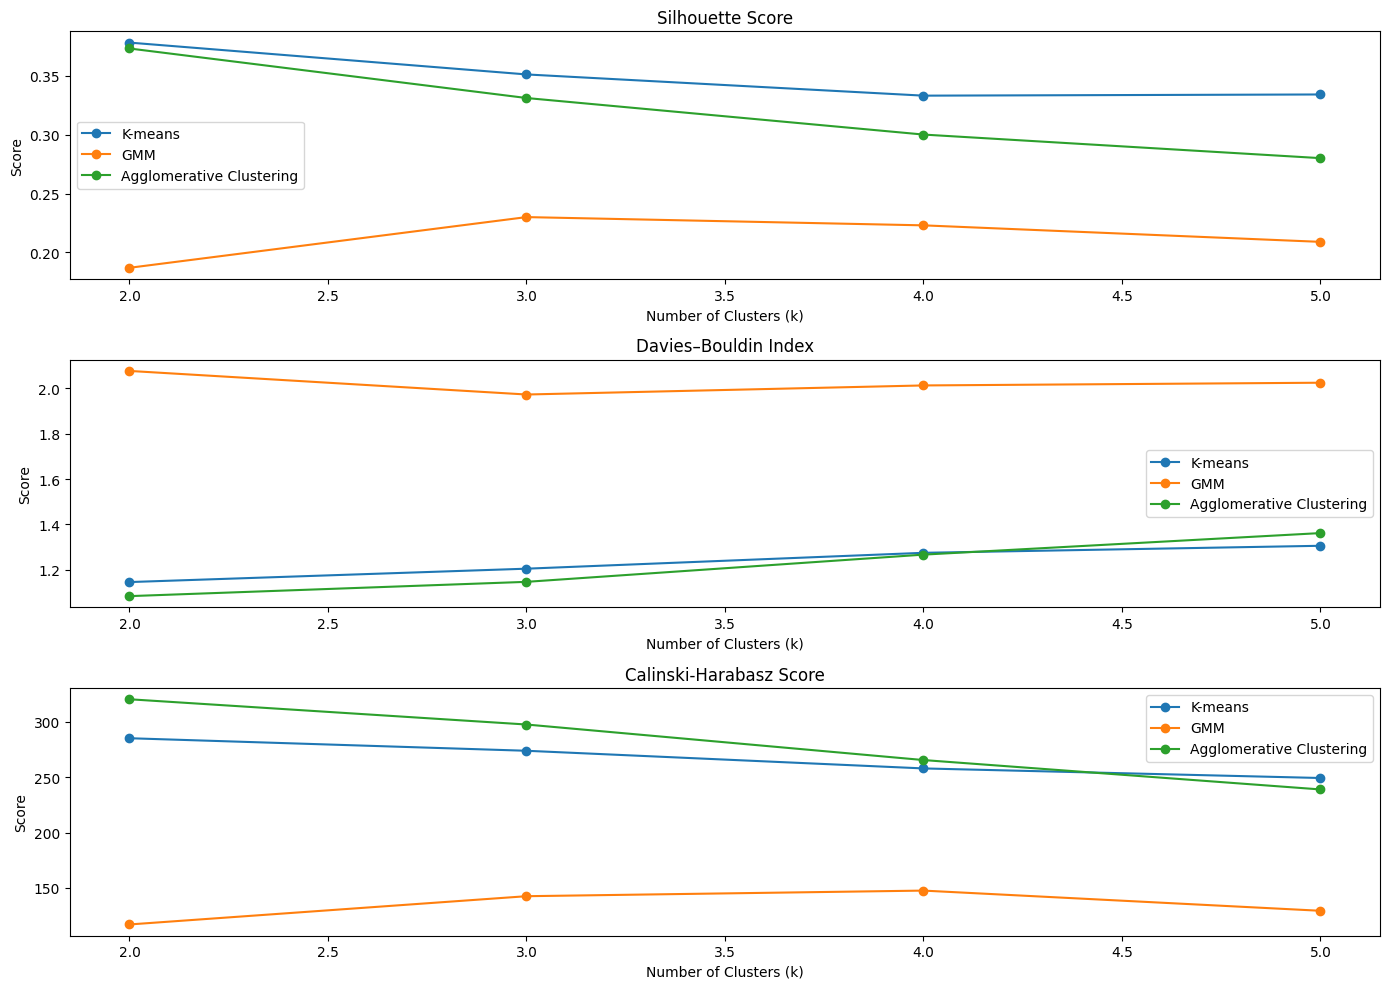

In [32]:
import matplotlib.pyplot as plt

# Define the range of k values
k_values = range(2, 6)

# Evaluation metrics for K-means (already calculated)
kmeans_silhouette_scores = [0.378, 0.351, 0.333, 0.334]
kmeans_davies_bouldin_scores = [1.146, 1.205, 1.275, 1.306]
kmeans_calinski_harabasz_scores = [285.245, 273.917, 257.962, 249.311]

# Evaluation metrics for GMM (already calculated)
gmm_silhouette_scores = [0.187, 0.230, 0.223, 0.209]
gmm_davies_bouldin_scores = [2.077, 1.973, 2.013, 2.025]
gmm_calinski_harabasz_scores = [116.970, 142.507, 147.573, 129.334]

# Evaluation metrics for Agglomerative Clustering (already calculated)
hierarchical_silhouette_scores = [0.373, 0.331, 0.300, 0.280]
hierarchical_davies_bouldin_scores = [1.084, 1.147, 1.267, 1.362]
hierarchical_calinski_harabasz_scores = [320.459, 297.639, 265.534, 238.972]

# Plot evaluation metrics
plt.figure(figsize=(14, 10))

# Silhouette Score
plt.subplot(3, 1, 1)
plt.plot(k_values, kmeans_silhouette_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_silhouette_scores, marker='o', label='GMM')
plt.plot(k_values, hierarchical_silhouette_scores, marker='o', label='Agglomerative Clustering')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')
plt.legend()

# Davies–Bouldin Index
plt.subplot(3, 1, 2)
plt.plot(k_values, kmeans_davies_bouldin_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_davies_bouldin_scores, marker='o', label='GMM')
plt.plot(k_values, hierarchical_davies_bouldin_scores, marker='o', label='Agglomerative Clustering')
plt.title('Davies–Bouldin Index')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')
plt.legend()

# Calinski-Harabasz Score
plt.subplot(3, 1, 3)
plt.plot(k_values, kmeans_calinski_harabasz_scores, marker='o', label='K-means')
plt.plot(k_values, gmm_calinski_harabasz_scores, marker='o', label='GMM')
plt.plot(k_values, hierarchical_calinski_harabasz_scores, marker='o', label='Agglomerative Clustering')
plt.title('Calinski-Harabasz Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()
